In [154]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
from zipfile import ZipFile

%matplotlib inline

In [2]:
data_dir = 'input_data'
file_name = "santander-value-prediction-challenge.zip"

with ZipFile(file_name, 'r') as zip_file: 
    for file in zip_file.namelist():
        if os.path.exists(data_dir + r'/' + file):
            pass
        else:
            zip_file.extract(file, data_dir)

In [3]:
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col='ID')
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

First, looking for any observations with N/A values in train data

In [36]:
list(filter(lambda x: x < len(train_df.columns), train_df.apply(lambda x: x.count(), axis=1)))

[]

No missing values - next examining the shape of the training data

In [17]:
train_df.shape

(4459, 4992)

As there are more features than values, I will have to consider approaches to dimensionality reduction. To begin with, exploring the features

In [33]:
train_df.columns

Index(['target', '48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00',
       '2f0771a37', '30347e683', 'd08d1fbe3', '6ee66e115', '20aa07010',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4992)

Feature names do not contain any meaningful information, so a reduction approach will need to be based on on predictive relevance

Now- examining the characteristics of the target data

In [14]:
train_df.target.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

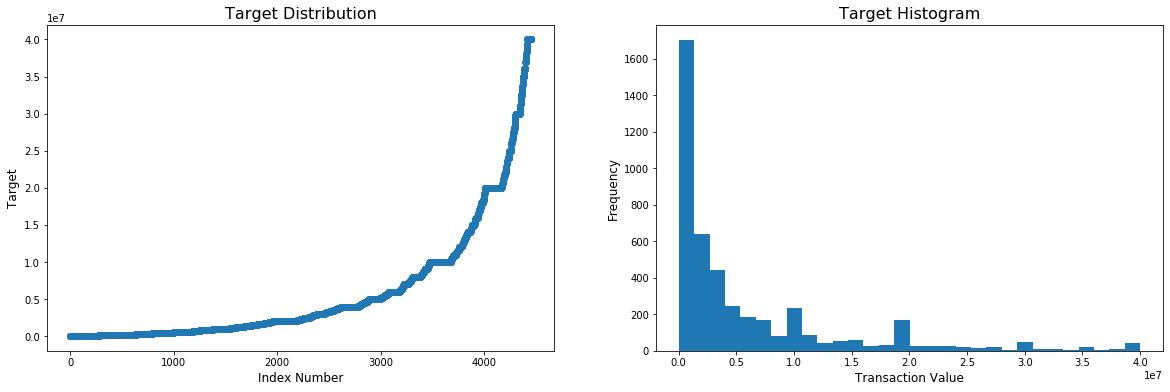

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
ax1.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
ax1.set_xlabel('Index Number', fontsize=12)
ax1.set_ylabel('Target', fontsize=12)
ax1.set_title("Target Distribution", fontsize=16)

ax2.hist(x=np.sort(train_df.target.values), bins=30)
ax2.set_xlabel('Transaction Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Target Histogram', fontsize=16)
plt.show()

There is a very high range of values in the train target, with significant outliers.

Now, exploring a log transform of the target data to see if it results in a more normal distribution

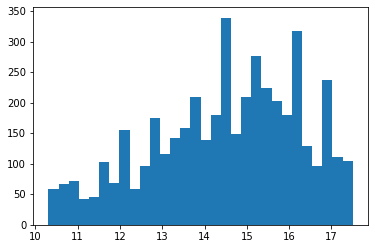

In [52]:
plt.hist(np.log(train_df.target.values), bins=30)
plt.show()

Looks like a log transform does fix the data skew issue. **Revisit this!**

In [57]:
correlation_matrix = train_df.corr(method='spearman')['target'][1:]

In [63]:
correlated_features = correlation_matrix[abs(correlation_matrix) > .1].sort_values(ascending=False)
correlated_features

f190486d6    0.107678
06b19b6c4   -0.100202
e2b4d4ef7   -0.100337
896d1c52d   -0.100381
912f4f5de   -0.100464
ea397d576   -0.100696
5a88e3d89   -0.100786
707f193d9   -0.101385
0eebebc7c   -0.101501
13d853d22   -0.101657
0c4bf4863   -0.101714
e9c7ccc05   -0.102174
83e2ae51c   -0.102465
fa6e76901   -0.103114
b6fa5a5fd   -0.104106
9e2040e5b   -0.104247
89db78d8e   -0.104448
fd9968f0d   -0.104548
45cda25bb   -0.104755
a8ef2a0d2   -0.104837
28dc3cc44   -0.104916
cbf236577   -0.104954
08d203407   -0.105278
dd85a900c   -0.105311
1d79bc053   -0.105551
cb162bd89   -0.106288
994b4c2ac   -0.106573
e5ac02d3c   -0.106720
2c136905e   -0.108038
cd8048913   -0.108488
f2520b601   -0.108505
fbe52b1b2   -0.108612
f41f0eb2f   -0.108897
e17f1f07c   -0.109022
e7071d5e3   -0.109869
67f9e982f   -0.110242
4f2f6b0b3   -0.110345
c7ae29e66   -0.110687
8485abcab   -0.111304
adadb9a96   -0.112109
7b1ddbabf   -0.112540
08af3dd45   -0.112729
715fa74a4   -0.112752
f8b733d3f   -0.113011
186b87c05   -0.113428
3adf5e2b5 

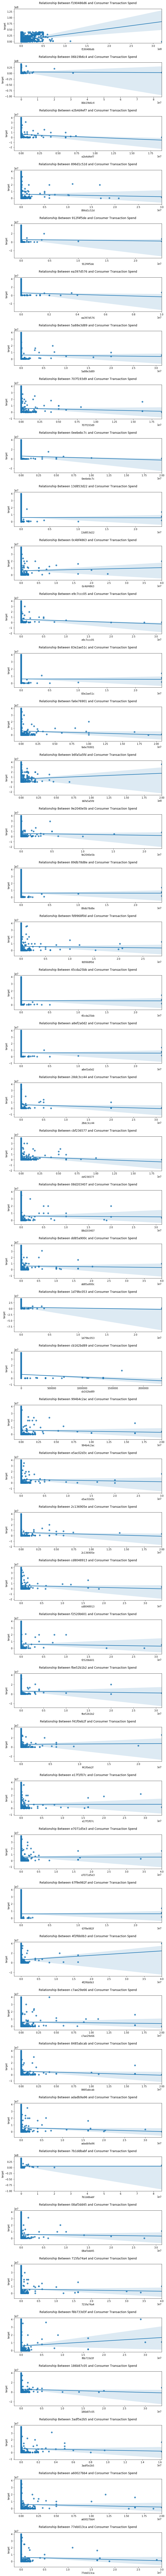

In [155]:
train_df = pd.concat([train_df.target, train_df[list(correlated_features.index)]], axis=1)

fig, subaxes = plt.subplots(ncols=1, nrows=len(train_df.columns[1:]), figsize=(10, 150))

for ax, col in zip(subaxes, train_df.iloc[:, 1:]):
    sns.regplot(train_df[col], train_df['target'], ax=ax)
    ax.set_title('Relationship Between {} and Consumer Transaction Spend'.format(col), fontsize=12, pad=20)

fig.tight_layout(pad=2.0)


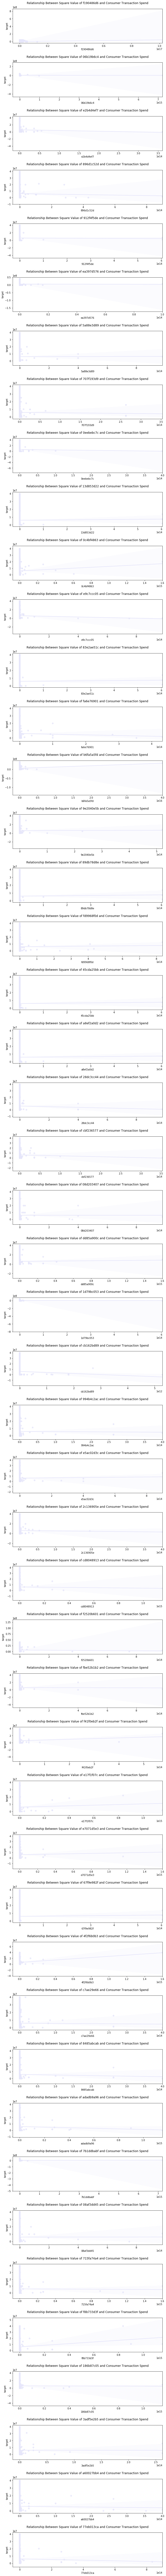

In [160]:
fig, subaxes = plt.subplots(ncols=1, nrows=len(train_df.columns[1:]), figsize=(10, 150))

for ax, col in zip(subaxes, train_df.iloc[:, 1:]):
    sns.regplot(np.square(train_df[col]), train_df['target'], ax=ax, color='lavender')
    ax.set_title('Relationship Between Square Value of {} and Consumer Transaction Spend'.format(col), fontsize=12, pad=20)
    
fig.tight_layout(pad=2.0)

# ONLY WHEN FINISHED

In [6]:
# Cleaning up csv files to reduce storage load on Github
import shutil

shutil.rmtree(data_dir)